# 模型选择 + 过拟合和欠拟合

>通过多项式拟合来交互探索

In [251]:
import math
import numpy as np
import torch
from torch import nn, optim
from torch.utils import data
import matplotlib.pyplot as plt

In [252]:
# 最大拟合项
max_degree = 100
# 训练样本规模
n_train, n_test = 10, 10
# 设定真实的权重
true_w = torch.zeros(max_degree)
true_w[:4] = torch.Tensor([5, -3.2, 8.4, -5.6]) / torch.FloatTensor([1, 2, 6, 24])
# true_w[:4] = torch.Tensor([5, 0, 0, 0]) / torch.FloatTensor([1, 2, 6, 24])
true_w = true_w.reshape((-1, 1))
true_b = .2

In [253]:
features = torch.rand(size=(n_train + n_test, 1))   # 生成原始的特征
features, _ = features.sort(dim=0)

In [254]:
# 特征工程: 生成多项式项
poly_features = features ** torch.arange(1, max_degree+1)

In [255]:
# 产生标签数据
labels = torch.matmul(poly_features, true_w) + true_b
y = labels
# labels += np.random.normal(scale=0.1, size=labels.shape).astype(dtype=np.float32)

In [256]:
labels.shape

torch.Size([20, 1])

## 可视化原始数据

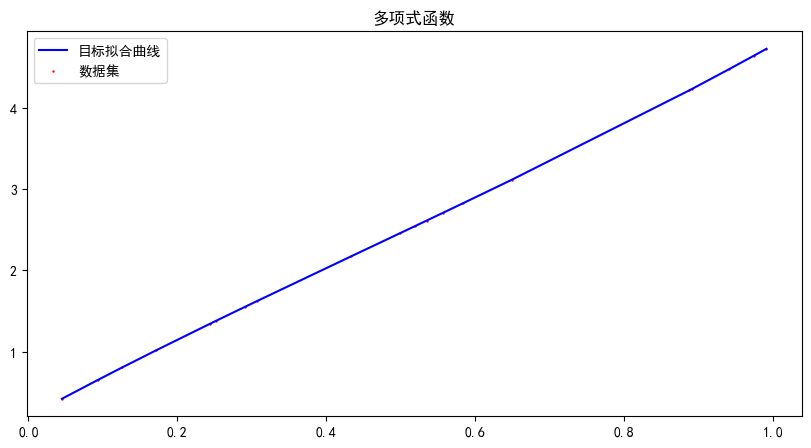

In [257]:
plt.figure(figsize=(10, 5))
plt.title("多项式函数")
plt.plot(features, y, c='b', label='目标拟合曲线')
plt.scatter(features, labels, s=0.5, c='r', label='数据集')
plt.legend()
plt.show()

## 构造训练数据集

In [258]:
def load_array(data_arrays, batch_size, is_train=True):
    """构造一个PyTorch的数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

## 定义神经网络

> 实现一个函数来评估模型在给定数据集上的损失 

In [259]:
def init_normal(m):
        if type(m) == nn.Linear:
            nn.init.normal_(m.weight, mean=0, std=0.01)
            nn.init.zeros_(m.bias)  

def train_polynomial_regression(features, labels, degree, num_epochs, learning_rate, vaild_feaures, vaild_labels):
    # Initialize the model, loss function, and optimizer
    model = nn.Sequential(nn.Linear(degree, 1))
    # model = nn.Sequential(
    #      nn.Linear(degree, degree*2), nn.ReLU(),
    #      nn.Linear(degree * 2, 1),
    # )
    # 初始化参数
    model.apply(init_normal)

    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    
    # 训练loss
    train_loss_list = []
    vaild_loss_list = []
    # Training loop
    train_data_iter = load_array((features, labels), 100)
    for epoch in range(num_epochs):
        for X, y in train_data_iter:
            l = criterion(model(X), y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()  # 参数更新
        with torch.no_grad():
            loss = criterion(model(features), labels)
            train_loss_list.append(loss.item())
            y_vaild = model(vaild_feaures)
            vaild_loss = criterion(y_vaild, vaild_labels)
            vaild_loss_list.append(vaild_loss.item())
    
    return model, train_loss_list, vaild_loss_list


In [260]:
# 随机选择 100 个作为训练集(下标采样)
train_index = np.random.choice(np.arange(0, n_train + n_test), n_train, replace=False)
test_index = np.array([i for i in np.arange(n_test + n_test) if i not in train_index])
train_index = np.sort(train_index)

In [261]:
vaild_y = labels[test_index].reshape(-1)
train_y = labels[train_index]
vaild_x = features[test_index].reshape(-1)
train_x = features[train_index].reshape(-1)

In [262]:
# train_y += np.random.normal(scale=0.2, size=train_y.shape).astype(dtype=np.float32)

In [263]:
train_x.min(), train_x.max(), vaild_x.min(), vaild_x.max()

(tensor(0.0450), tensor(0.9744), tensor(0.1717), tensor(0.9916))

In [264]:
# 拟合项
def overfitting_show(features, poly_features, labels, degrees, num_epochs, learning_rate):
    """
    :param poly_feateures: 多项式特征
    :param labels: 标签
    :param degress: 特征阶数
    ...
    """
    test_labels = labels[test_index]
    train_labels = labels[train_index]
    hats = {}
    for degree in degrees:
        train_features = poly_features[train_index,:degree]
        test_features = poly_features[test_index,:degree]
        # Train the model
        model, train_loss, vaild_loss = train_polynomial_regression(train_features, train_labels, degree, num_epochs, learning_rate, test_features, test_labels)

        # Test the model
        hats[degree] = dict(
            train_loss=train_loss,
            vaild_loss=vaild_loss,
            model=model,
        )
    
    return hats

In [265]:
degrees = [1, 4,  5, 10, 19, 100]
# degrees = [1, 3, 4, 10, 15]
num_epochs = 1000
learning_rate = 0.001

In [266]:
hats = overfitting_show(
    features.clone(), 
    poly_features.clone(), 
    labels.clone(),
    degrees,
    num_epochs,
    learning_rate
    )

OrderedDict([('0.weight', tensor([[1.1365]])), ('0.bias', tensor([1.4269]))])


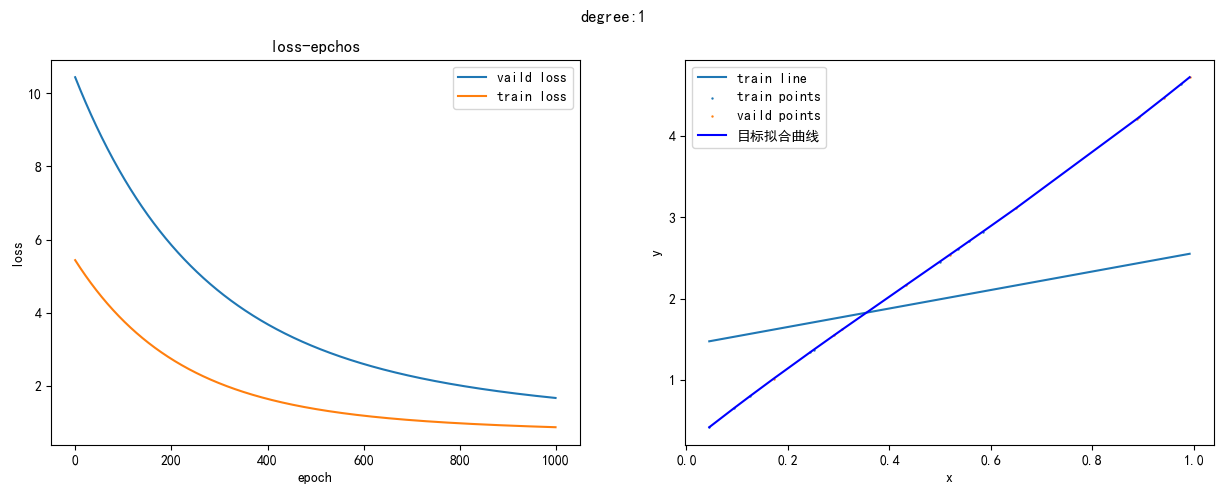

OrderedDict([('0.weight', tensor([[0.9310, 0.6952, 0.5472, 0.4623]])), ('0.bias', tensor([1.2646]))])


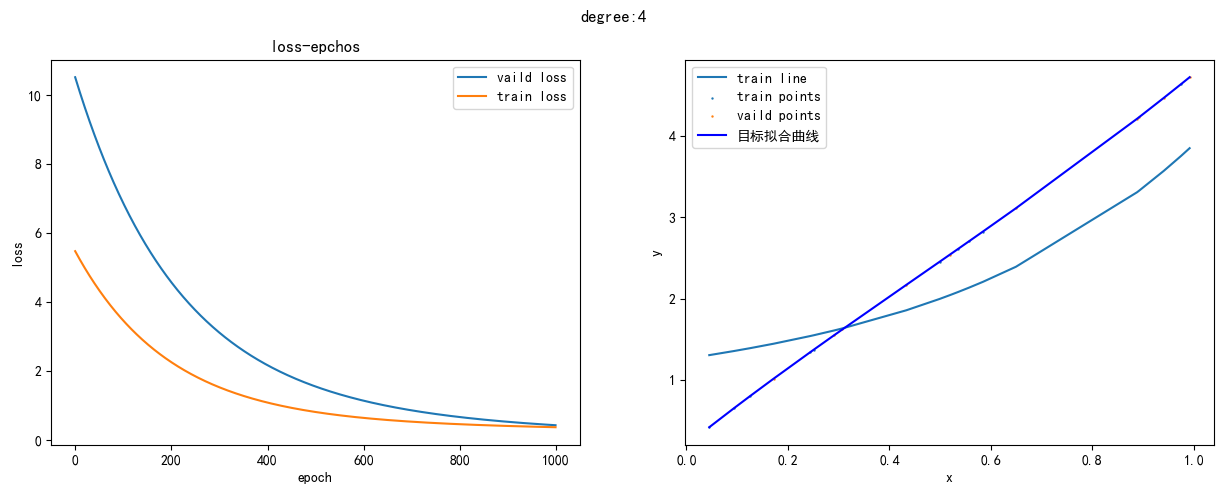

OrderedDict([('0.weight', tensor([[0.9067, 0.6731, 0.5163, 0.4340, 0.3786]])), ('0.bias', tensor([1.2481]))])


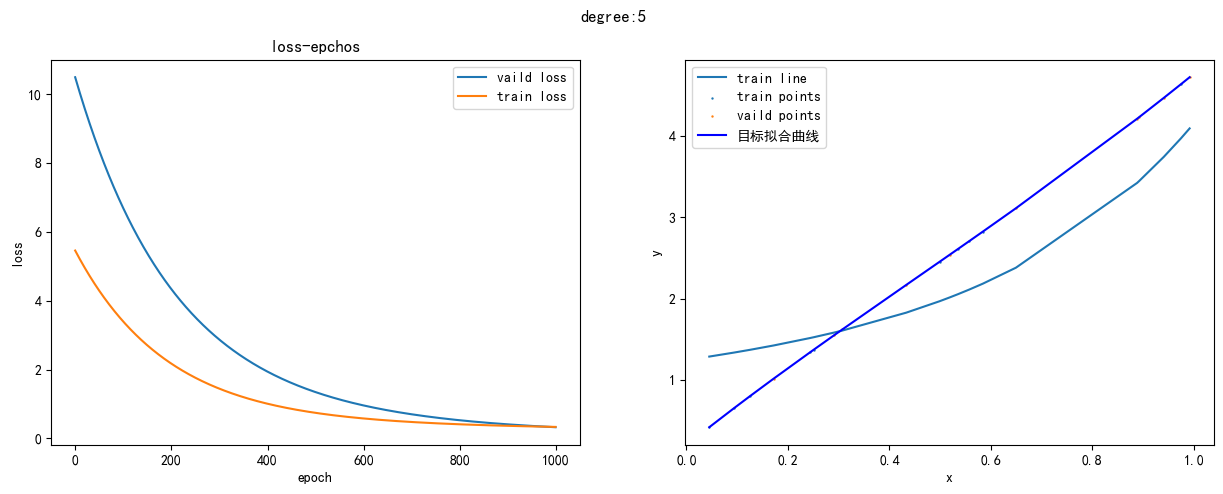

OrderedDict([('0.weight', tensor([[0.8373, 0.5640, 0.4373, 0.3348, 0.3097, 0.2618, 0.2620, 0.2193, 0.2463,
         0.2342]])), ('0.bias', tensor([1.2167]))])


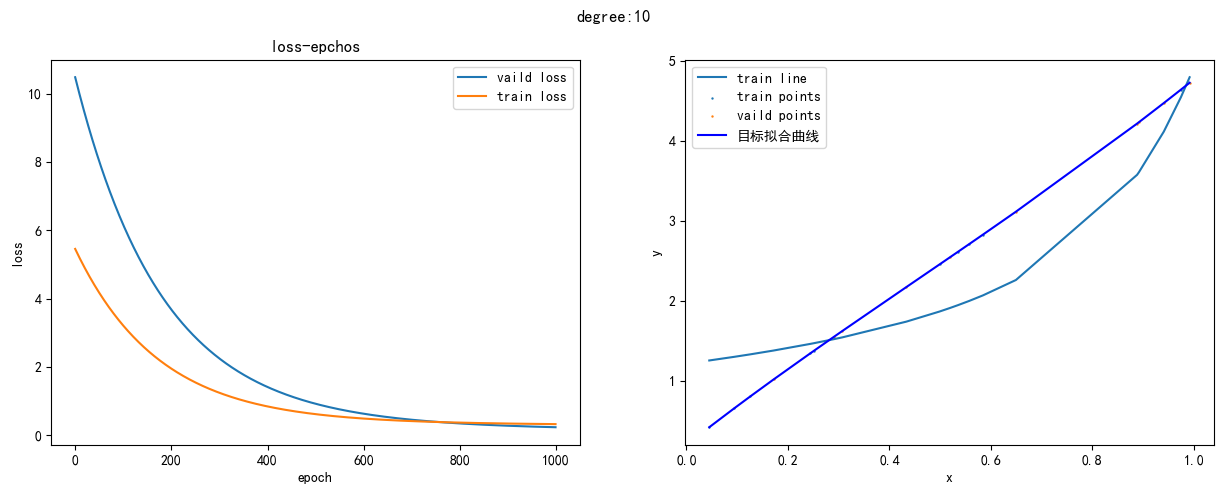

OrderedDict([('0.weight', tensor([[0.7815, 0.5100, 0.3665, 0.2837, 0.2456, 0.1965, 0.1863, 0.1775, 0.1919,
         0.1495, 0.1474, 0.1362, 0.1391, 0.1364, 0.1374, 0.1301, 0.1372, 0.1297,
         0.1169]])), ('0.bias', tensor([1.2011]))])


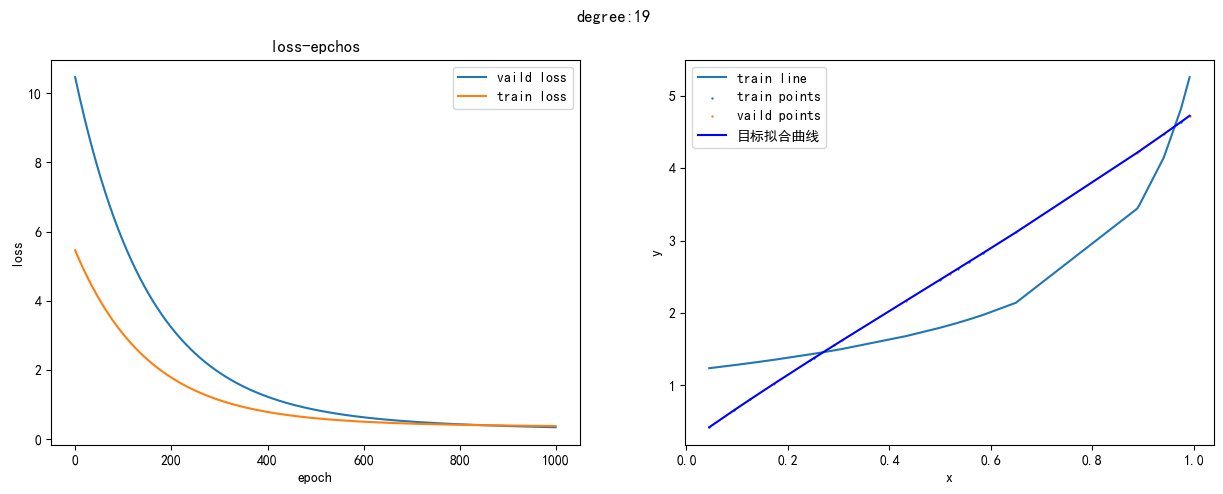

OrderedDict([('0.weight', tensor([[ 7.4227e-01,  4.6472e-01,  3.0163e-01,  2.2052e-01,  1.5667e-01,
          1.4128e-01,  1.2312e-01,  1.0658e-01,  1.0290e-01,  1.0778e-01,
          1.1146e-01,  8.3905e-02,  9.5276e-02,  8.7570e-02,  9.5273e-02,
          1.0356e-01,  7.1369e-02,  9.7340e-02,  8.8511e-02,  6.5591e-02,
          7.8392e-02,  6.9181e-02,  6.6844e-02,  6.7713e-02,  7.6816e-02,
          5.6568e-02,  8.1856e-02,  5.7876e-02,  5.8724e-02,  5.0323e-02,
          3.3400e-02,  5.0683e-02,  5.2737e-02,  5.9109e-02,  5.6184e-02,
          4.5079e-02,  6.3187e-02,  6.3593e-02,  5.3087e-02,  3.5724e-02,
          4.6430e-02,  3.8499e-02,  5.9859e-02,  3.8962e-02,  2.8431e-02,
          1.8840e-02,  4.9812e-02,  3.7639e-02,  4.4365e-02,  5.6615e-02,
          2.8645e-02,  5.0205e-02,  2.1279e-02,  4.9244e-02,  3.5515e-02,
          3.2794e-02,  1.1657e-02,  2.1627e-02,  1.4079e-02,  1.4073e-02,
          3.0440e-02,  4.5607e-02,  4.8123e-02,  1.3355e-02,  2.9136e-02,
          1.

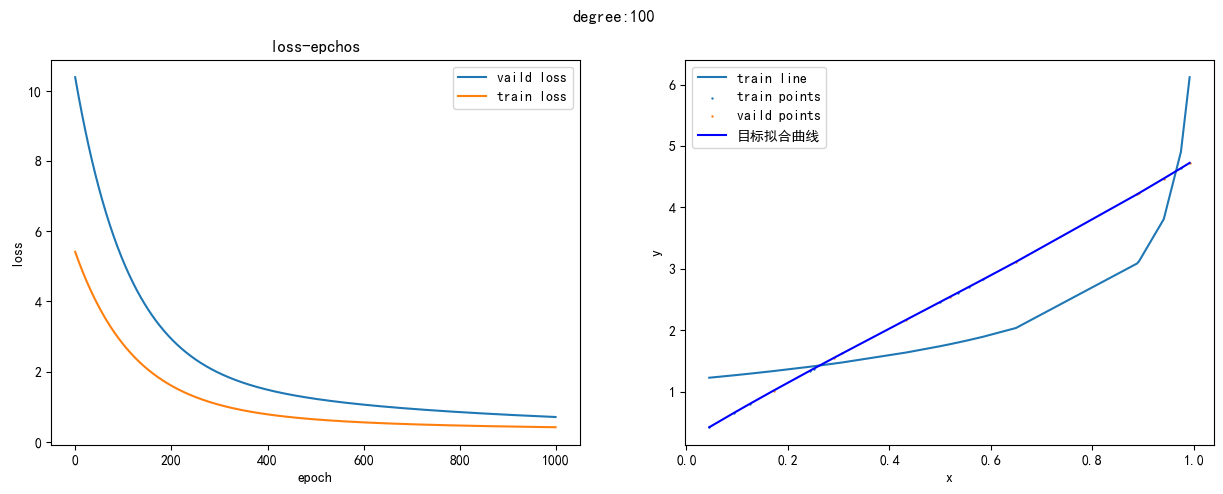

In [267]:
for degree, hat in hats.items():
    vaild_loss = hat['vaild_loss']
    train_loss = hat['train_loss']
    model = hat['model']
    y_all_hat = model(poly_features[:, :degree]).reshape(-1).detach().numpy()
    # print(y_all_hat.shape, features.reshape(-1).shape)
    print(model.state_dict())
    x = np.arange(len(vaild_loss))
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(f"degree:{degree}")
    axs[0].set_title("loss-epchos")
    axs[0].set_xlabel('epoch')
    axs[0].set_ylabel('loss')
    axs[0].plot(x, vaild_loss, label='vaild loss')
    axs[0].plot(x, train_loss, label='train loss')
    axs[1].plot(features.reshape(-1).detach().numpy(), y_all_hat, label='train line')
    axs[1].scatter(train_x, train_y, s=0.5, label='train points')
    axs[1].scatter(vaild_x, vaild_y, s=0.5, label='vaild points')
    plt.plot(features, y, c='b', label='目标拟合曲线')
    axs[1].set_xlabel('x')
    axs[1].set_ylabel('y')
    for ax in axs:
        ax.legend()
    plt.show()